In [36]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
import warnings
warnings.filterwarnings('ignore')  

# Setting display options for pandas DataFrame
pd.set_option('display.max_columns', None)  # Displaying all columns of a DataFrame
pd.set_option('display.expand_frame_repr', False)  # Disabling frame expansion
pd.set_option('max_colwidth', None)


In [37]:
df=  pd.read_csv('C:\IPL_all_matches.csv')

In [38]:
df.head()

,match_id,season,start_date,venue,innings,ball,batting_team,bowling_team,striker,non_striker,bowler,runs_off_bat,extras,wides,noballs,byes,legbyes,penalty,wicket_type,player_dismissed,other_wicket_type,other_player_dismissed
0,335982,2008,2008-04-18,M Chinnaswamy Stadium,2,6.8,Royal Challengers Bangalore,Kolkata Knight Riders,MV Boucher,CL White,AB Agarkar,4,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,335982,2008,2008-04-18,M Chinnaswamy Stadium,2,2.7,Royal Challengers Bangalore,Kolkata Knight Riders,W Jaffer,JH Kallis,AB Dinda,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,335982,2008,2008-04-18,M Chinnaswamy Stadium,2,3.1,Royal Challengers Bangalore,Kolkata Knight Riders,W Jaffer,JH Kallis,I Sharma,2,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,335982,2008,2008-04-18,M Chinnaswamy Stadium,2,3.2,Royal Challengers Bangalore,Kolkata Knight Riders,W Jaffer,JH Kallis,I Sharma,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,335982,2008,2008-04-18,M Chinnaswamy Stadium,2,3.3,Royal Challengers Bangalore,Kolkata Knight Riders,JH Kallis,W Jaffer,I Sharma,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [39]:
df.columns

Index(['match_id', 'season', 'start_date', 'venue', 'innings', 'ball',
       'batting_team', 'bowling_team', 'striker', 'non_striker', 'bowler',
       'runs_off_bat', 'extras', 'wides', 'noballs', 'byes', 'legbyes',
       'penalty', 'wicket_type', 'player_dismissed', 'other_wicket_type',
       'other_player_dismissed'],
      dtype='object')

In [40]:
# Rename  'striker' to 'batsman'
df.rename(columns = {'striker':'batsman'},inplace=True)

# Rename 'runs_off_bat' column to 'batsman_runs'
df.rename(columns={'runs_off_bat': 'batsman_runs'}, inplace=True)

[ Problem Statement: ]
How good is player X against CSK in 'MA Chidambaram Stadium, Chepauk' when they’re playing 3 spinners?

Filters in our problem statement:

.Stadium = 'MA Chidambaram Stadium, Chepauk'
.Phase = 'Middle Overs'
.Oppostion Team = 'Chennai Super Kings'

In [41]:
def phase(ball):
    if ball <= 5.6:
        return 'Powerplay'
    elif ball <= 14.6:
        return 'Middle'
    else:
        return 'Death'

In [42]:
df['phase'] = df['ball'].apply(lambda x: phase(x))

In [43]:
df.columns

Index(['match_id', 'season', 'start_date', 'venue', 'innings', 'ball',
       'batting_team', 'bowling_team', 'batsman', 'non_striker', 'bowler',
       'batsman_runs', 'extras', 'wides', 'noballs', 'byes', 'legbyes',
       'penalty', 'wicket_type', 'player_dismissed', 'other_wicket_type',
       'other_player_dismissed', 'phase'],
      dtype='object')

In [44]:
def balls_per_dismissal(balls, dismissals):
    if dismissals > 0:
        return balls/dismissals
    else:
        return balls/1

def balls_per_boundary(balls, boundaries):
    if boundaries > 0:
        return balls/boundaries
    else:
        return balls/1
    
def ByCustom(df, current_venue, current_phase, current_opposition):
    
    df = df[df.venue == current_venue]
    df = df[df.phase == current_phase]
    df = df[df.bowling_team == current_opposition]
    
    df.reset_index(inplace = True, drop = True)
    
    df['isDot'] = df['batsman_runs'].apply(lambda x: 1 if x == 0 else 0)
    df['isOne'] = df['batsman_runs'].apply(lambda x: 1 if x == 1 else 0)
    df['isTwo'] = df['batsman_runs'].apply(lambda x: 1 if x == 2 else 0)
    df['isThree'] = df['batsman_runs'].apply(lambda x: 1 if x == 3 else 0)
    df['isFour'] = df['batsman_runs'].apply(lambda x: 1 if x == 4 else 0)
    df['isSix'] = df['batsman_runs'].apply(lambda x: 1 if x == 6 else 0)
    
    runs = pd.DataFrame(df.groupby(['batsman', 'match_id'])['batsman_runs'].sum().reset_index()).groupby(['batsman'])['batsman_runs'].sum().reset_index().rename(columns={'batsman_runs':'runs'})
    innings = pd.DataFrame(df.groupby(['batsman'])['match_id'].apply(lambda x: len(list(np.unique(x)))).reset_index()).rename(columns = {'match_id':'innings'})
    balls = pd.DataFrame(df.groupby(['batsman'])['match_id'].count()).reset_index().rename(columns = {'match_id':'balls'})
    dismissals = pd.DataFrame(df.groupby(['batsman'])['player_dismissed'].count()).reset_index().rename(columns = {'player_dismissed':'dismissals'})
    
    dots = pd.DataFrame(df.groupby(['batsman'])['isDot'].sum()).reset_index().rename(columns = {'isDot':'dots'})
    ones = pd.DataFrame(df.groupby(['batsman'])['isOne'].sum()).reset_index().rename(columns = {'isOne':'ones'})
    twos = pd.DataFrame(df.groupby(['batsman'])['isTwo'].sum()).reset_index().rename(columns = {'isTwo':'twos'})
    threes = pd.DataFrame(df.groupby(['batsman'])['isThree'].sum()).reset_index().rename(columns = {'isThree':'threes'})
    fours = pd.DataFrame(df.groupby(['batsman'])['isFour'].sum()).reset_index().rename(columns = {'isFour':'fours'})
    sixes = pd.DataFrame(df.groupby(['batsman'])['isSix'].sum()).reset_index().rename(columns = {'isSix':'sixes'})
    
    df = pd.merge(innings, runs, on = 'batsman').merge(balls, on = 'batsman').merge(dismissals, on = 'batsman').merge(dots, on = 'batsman').merge(ones, on = 'batsman').merge(twos, on = 'batsman').merge(threes, on = 'batsman').merge(fours, on = 'batsman').merge(sixes, on = 'batsman')
    
    #StrikeRate
    df['SR'] = df.apply(lambda x: 100*(x['runs']/x['balls']), axis = 1)

    #runs per innings
    df['RPI'] = df.apply(lambda x: x['runs']/x['innings'], axis = 1)

    #balls per dismissals
    df['BPD'] = df.apply(lambda x: balls_per_dismissal(x['balls'], x['dismissals']), axis = 1)

    #balls per boundary
    df['BPB'] = df.apply(lambda x: balls_per_boundary(x['balls'], (x['fours'] + x['sixes'])), axis = 1)
    
    df['dot_percentage'] = df.apply(lambda x: x['dots']/x['balls'], axis = 1)
    
    return df

In [45]:
df['bowling_team']. unique()

array(['Kolkata Knight Riders', 'Royal Challengers Bangalore',
       'Delhi Daredevils', 'Rajasthan Royals', 'Chennai Super Kings',
       'Kings XI Punjab', 'Mumbai Indians', 'Deccan Chargers',
       'Kochi Tuskers Kerala', 'Pune Warriors', 'Sunrisers Hyderabad',
       'Rising Pune Supergiants', 'Gujarat Lions',
       'Rising Pune Supergiant', 'Delhi Capitals', 'Punjab Kings',
       'Lucknow Super Giants', 'Gujarat Titans'], dtype=object)

In [46]:
df1 = ByCustom(df,'MA Chidambaram Stadium, Chepauk', 'Middle', 'Chennai Super Kings')

In [47]:
df1

,batsman,innings,runs,balls,dismissals,dots,ones,twos,threes,fours,sixes,SR,RPI,BPD,BPB,dot_percentage
0,A Mishra,1,14,16,1,9,4,1,0,2,0,87.500000,14.000000,16.0,8.000000,0.562500
1,A Mithun,1,11,8,1,3,3,0,0,2,0,137.500000,11.000000,8.0,4.000000,0.375000
2,A Symonds,1,26,26,0,12,10,1,0,2,1,100.000000,26.000000,26.0,8.666667,0.461538
3,AB Agarkar,1,6,2,0,0,0,1,0,1,0,300.000000,6.000000,2.0,2.000000,0.000000
4,AB de Villiers,4,88,61,1,17,26,5,2,10,1,144.262295,22.000000,61.0,5.545455,0.278689
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110,Y Nagar,1,19,26,0,8,17,1,0,0,0,73.076923,19.000000,26.0,26.000000,0.307692
111,Y Venugopal Rao,3,67,51,1,16,27,1,0,2,5,131.372549,22.333333,51.0,7.285714,0.313725
112,YK Pathan,4,29,35,1,16,15,2,0,1,1,82.857143,7.250000,35.0,17.500000,0.457143
113,Yuvraj Singh,4,66,58,2,22,24,5,0,5,2,113.793103,16.500000,29.0,8.285714,0.379310


In [48]:
df1['innings'].unique()

array([1, 4, 2, 3, 5, 7], dtype=int64)

In [49]:
filterred_df_costom=df1[df1['innings']>= 2]

In [50]:
filterred_df_costom

,batsman,innings,runs,balls,dismissals,dots,ones,twos,threes,fours,sixes,SR,RPI,BPD,BPB,dot_percentage
4,AB de Villiers,4,88,61,1,17,26,5,2,10,1,144.262295,22.000000,61.000000,5.545455,0.278689
6,AD Mathews,2,42,36,0,12,18,2,0,2,2,116.666667,21.000000,36.000000,9.000000,0.333333
9,AL Menaria,2,22,30,1,14,12,3,0,1,0,73.333333,11.000000,30.000000,30.000000,0.466667
13,AT Rayudu,4,26,37,2,12,24,1,0,0,0,70.270270,6.500000,18.500000,37.000000,0.324324
22,CL White,2,40,38,1,14,18,1,0,5,0,105.263158,20.000000,38.000000,7.600000,0.368421
24,DA Miller,3,38,32,1,8,18,3,0,2,1,118.750000,12.666667,32.000000,10.666667,0.250000
25,DA Warner,3,72,73,2,28,32,9,0,1,3,98.630137,24.000000,36.500000,18.250000,0.383562
27,DJ Bravo,2,26,20,2,7,9,0,1,2,1,130.000000,13.000000,10.000000,6.666667,0.350000
29,DJ Hussey,2,22,17,2,7,6,1,0,2,1,129.411765,11.000000,8.500000,5.666667,0.411765
32,DPMD Jayawardene,3,36,35,3,13,16,4,0,0,2,102.857143,12.000000,11.666667,17.500000,0.371429


In [51]:
wt_sr, wt_rpi, wt_bpd, wt_dot_percentage = 0.13, 0.27, 0.16, 0.45

**Calculation - Normalizing all values to same dimensions**

In [52]:
# Step 1: Square of all values
filterred_df_costom['calc_SR'] = filterred_df_costom['SR'].apply(lambda x: x*x) 
filterred_df_costom['calc_RPI'] = filterred_df_costom['RPI'].apply(lambda x: x*x) 
filterred_df_costom['calc_BPD'] = filterred_df_costom['BPD'].apply(lambda x: x*x) 
filterred_df_costom['calc_dot_percentage'] = filterred_df_costom['dot_percentage'].apply(lambda x: x*x)

sq_sr, sq_rpi, sq_bpd, sq_dot_percentage = np.sqrt(filterred_df_costom[['calc_SR','calc_RPI', 'calc_BPD', 'calc_dot_percentage']].sum(axis=0))

filterred_df_costom['calc_SR'] = filterred_df_costom['calc_SR'].apply(lambda x: x/sq_sr) 
filterred_df_costom['calc_RPI'] = filterred_df_costom['calc_RPI'].apply(lambda x: x/sq_rpi) 
filterred_df_costom['calc_BPD'] = filterred_df_costom['calc_BPD'].apply(lambda x: x/sq_bpd) 
filterred_df_costom['calc_dot_percentage'] = filterred_df_costom['calc_dot_percentage'].apply(lambda x: x/sq_dot_percentage)

filterred_df_costom['calc_SR'] = filterred_df_costom['calc_SR'].apply(lambda x: x*wt_sr) 
filterred_df_costom['calc_RPI'] = filterred_df_costom['calc_RPI'].apply(lambda x: x*wt_rpi) 
filterred_df_costom['calc_BPD'] = filterred_df_costom['calc_BPD'].apply(lambda x: x*wt_bpd) 
filterred_df_costom['calc_dot_percentage'] = filterred_df_costom['calc_dot_percentage'].apply(lambda x: x*wt_dot_percentage)

best_sr, worst_sr = max(filterred_df_costom['calc_SR']), min(filterred_df_costom['calc_SR'])
best_rpi, worst_rpi = max(filterred_df_costom['calc_RPI']), min(filterred_df_costom['calc_RPI'])
best_bpd, worst_bpd = max(filterred_df_costom['calc_BPD']), min(filterred_df_costom['calc_BPD'])
best_dot_percentage, worst_dot_percentage = min(filterred_df_costom['calc_dot_percentage']), max(filterred_df_costom['calc_dot_percentage'])

In [53]:
filterred_df_costom.head()

,batsman,innings,runs,balls,dismissals,dots,ones,twos,threes,fours,sixes,SR,RPI,BPD,BPB,dot_percentage,calc_SR,calc_RPI,calc_BPD,calc_dot_percentage
4,AB de Villiers,4,88,61,1,17,26,5,2,10,1,144.262295,22.0,61.0,5.545455,0.278689,3.936540,1.232133,2.922988,0.013834
6,AD Mathews,2,42,36,0,12,18,2,0,2,2,116.666667,21.0,36.0,9.000000,0.333333,2.574558,1.122667,1.018058,0.019791
9,AL Menaria,2,22,30,1,14,12,3,0,1,0,73.333333,11.0,30.0,30.000000,0.466667,1.017213,0.308033,0.706985,0.038790
13,AT Rayudu,4,26,37,2,12,24,1,0,0,0,70.270270,6.5,18.5,37.000000,0.324324,0.934012,0.107557,0.268851,0.018735
22,CL White,2,40,38,1,14,18,1,0,5,0,105.263158,20.0,38.0,7.600000,0.368421,2.095858,1.018292,1.134317,0.024177


**#Calculation - Comparision against the best & worst values**

In [54]:
# Deviation from the best values
filterred_df_costom['dev_best_SR'] = filterred_df_costom['calc_SR'].apply(lambda x: (x - best_sr) * (x - best_sr)) 
filterred_df_costom['dev_best_RPI'] = filterred_df_costom['calc_RPI'].apply(lambda x: (x - best_rpi) * (x - best_rpi)) 
filterred_df_costom['dev_best_BPD'] = filterred_df_costom['calc_BPD'].apply(lambda x: (x - best_bpd) * (x - best_bpd)) 
filterred_df_costom['dev_best_dot_percentage'] = filterred_df_costom['calc_dot_percentage'].apply(lambda x: (x - best_dot_percentage) * (x - best_dot_percentage))

# Total deviation from the best values
filterred_df_costom['dev_best_sqrt'] = filterred_df_costom.apply(lambda x: x['dev_best_SR'] + x['dev_best_RPI'] + x['dev_best_BPD'] + x['dev_best_dot_percentage'], axis=1) 

# Deviation from the worst values
filterred_df_costom['dev_worst_SR'] = filterred_df_costom['calc_SR'].apply(lambda x: (x - worst_sr) * (x - worst_sr)) 
filterred_df_costom['dev_worst_RPI'] = filterred_df_costom['calc_RPI'].apply(lambda x: (x - worst_rpi) * (x - worst_rpi)) 
filterred_df_costom['dev_worst_BPD'] = filterred_df_costom['calc_BPD'].apply(lambda x: (x - worst_bpd) * (x - worst_bpd)) 
filterred_df_costom['dev_worst_dot_percentage'] = filterred_df_costom['calc_dot_percentage'].apply(lambda x: (x - worst_dot_percentage) * (x - worst_dot_percentage))

# Total deviation from the worst values
filterred_df_costom['dev_worst_sqrt'] = filterred_df_costom.apply(lambda x: x['dev_worst_SR'] + x['dev_worst_RPI'] + x['dev_worst_BPD'] + x['dev_worst_dot_percentage'], axis=1)

**Final Step - Overall score for each player ( values from 0 - 1)**

In [55]:
filterred_df_costom['score'] = filterred_df_costom.apply(lambda x: x['dev_worst_sqrt']/(x['dev_worst_sqrt'] + x['dev_best_sqrt']), axis = 1)

In [56]:
filterred_df_costom.head()

,batsman,innings,runs,balls,dismissals,dots,ones,twos,threes,fours,sixes,SR,RPI,BPD,BPB,dot_percentage,calc_SR,calc_RPI,calc_BPD,calc_dot_percentage,dev_best_SR,dev_best_RPI,dev_best_BPD,dev_best_dot_percentage,dev_best_sqrt,dev_worst_SR,dev_worst_RPI,dev_worst_BPD,dev_worst_dot_percentage,dev_worst_sqrt,score
4,AB de Villiers,4,88,61,1,17,26,5,2,10,1,144.262295,22.0,61.0,5.545455,0.278689,3.936540,1.232133,2.922988,0.013834,9.482933,3.338908,2.237014,0.000060,15.058915,14.255385,1.511885,8.525502,0.005705,24.298477,0.617380
6,AD Mathews,2,42,36,0,12,18,2,0,2,2,116.666667,21.0,36.0,9.000000,0.333333,2.574558,1.122667,1.018058,0.019791,19.726210,3.750940,11.564051,0.000187,35.041389,5.825695,1.254671,1.030054,0.004841,8.115261,0.188042
9,AL Menaria,2,22,30,1,14,12,3,0,1,0,73.333333,11.0,30.0,30.000000,0.466667,1.017213,0.308033,0.706985,0.038790,35.985175,7.570024,13.776486,0.001068,57.332753,0.733255,0.093323,0.495394,0.002558,1.324530,0.022581
13,AT Rayudu,4,26,37,2,12,24,1,0,0,0,70.270270,6.5,18.5,37.000000,0.324324,0.934012,0.107557,0.268851,0.018735,36.990308,8.713382,17.220865,0.000159,62.924714,0.597686,0.011027,0.070601,0.004989,0.684304,0.010758
22,CL White,2,40,38,1,14,18,1,0,5,0,105.263158,20.0,38.0,7.600000,0.368421,2.095858,1.018292,1.134317,0.024177,24.207577,4.166127,10.786863,0.000326,39.160893,3.744024,1.031740,1.279558,0.004250,6.059571,0.134001


In [57]:
filterred_df_costom[['batsman', 'score']].sort_values(by='score', ascending=False).reset_index().drop(columns=['index'])

,batsman,score
0,SE Marsh,0.931495
1,SR Watson,0.717881
2,AB de Villiers,0.617380
3,G Gambhir,0.577196
4,NV Ojha,0.448379
5,Y Venugopal Rao,0.401966
6,MS Bisla,0.388796
7,V Kohli,0.203129
8,DJ Bravo,0.189141
9,AD Mathews,0.188042


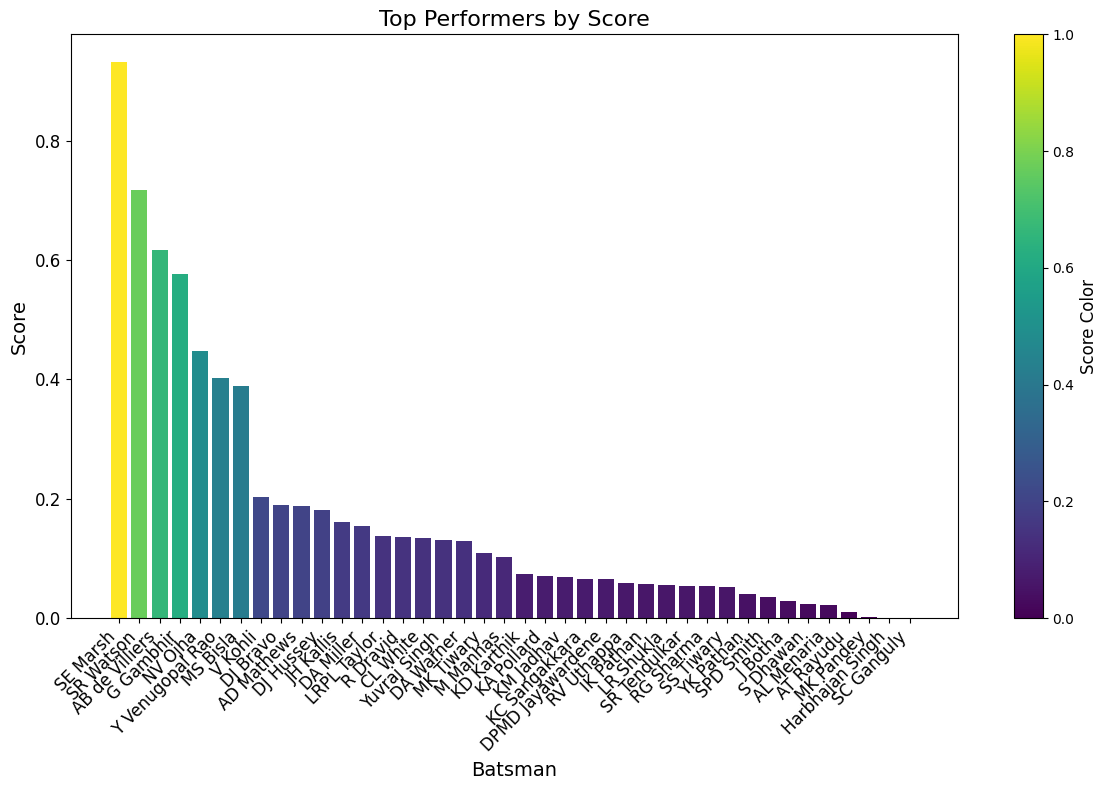

In [60]:
# Assuming filterred_df_costom is your DataFrame containing batsman and score columns
sorted_df = filterred_df_costom[['batsman', 'score']].sort_values(by='score', ascending=False).reset_index(drop=True)

# Create a bar plot
plt.figure(figsize=(12, 8))
bars = plt.bar(sorted_df['batsman'], sorted_df['score'], color=plt.cm.viridis(sorted_df['score']/max(sorted_df['score'])))  # Using Viridis color map for color variation
plt.title('Top Performers by Score', fontsize=16)
plt.xlabel('Batsman', fontsize=14)
plt.ylabel('Score', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)

# Add color bar
cbar = plt.colorbar(plt.cm.ScalarMappable(cmap='viridis'), ax=plt.gca())
cbar.set_label('Score Color', fontsize=12)

# Show plot
plt.tight_layout()
plt.show()

**[Observations]
The plot highlights the top performers against CSK at the MA Chidambaram Stadium, Chepauk, during the middle overs, particularly when facing three spinners. SE Marsh emerges as the standout performer, followed by SR Watson and AB de Villiers. The color gradient effectively distinguishes between the scores, with darker shades indicating higher performance levels. This analysis sheds light on the effectiveness of batsmen in navigating the challenges posed by CSK's spinners in the middle overs at the iconic Chepauk stadium.**